## Importing Libraries

In [1]:
import torch
import torch.nn as nn
import torchvision

from torch.utils.data import (
    Dataset,
    DataLoader,
)

from torchvision.datasets import ImageFolder
from torchvision.transforms import (
    RandomResizedCrop,
    RandomHorizontalFlip,
    RandomVerticalFlip,
    ColorJitter,
    RandomGrayscale,
    RandomApply,
    Compose,
    GaussianBlur,
    Resize,
    ToTensor,
    RandomRotation,
    RandomAffine,
    Normalize
)
# from torchlars import LARS
import torchvision.models as models

import os
import glob
import time
from skimage import io
import matplotlib.pyplot as plt
from PIL import Image

/home/ccet/anaconda3/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
print(f'Torch-Version {torch.__version__}')
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'DEVICE: {DEVICE}')

Torch-Version 1.10.2+cu102
DEVICE: cuda


## SimCLR transformations

In [3]:
def get_complete_transform(output_shape, kernel_size, s=1.0):
    """
    The color distortion transform.
    
    Args:
        s: Strength parameter.
    
    Returns:
        A color distortion transform.
    """
    rnd_crop = Resize(output_shape)    # random crop
    rnd_flip = RandomHorizontalFlip(p=0.5)     # random flip
    rnd_vflip= RandomVerticalFlip(p=0.5)
    rnd_rotate = RandomRotation(degrees=(-90, 90), fill=(0,))
#     color_jitter = ColorJitter(0.01*s, 0.02*s, 0.08*s, 0.1*s)
#     rnd_color_jitter = RandomApply([color_jitter], p=0.8)      # random color jitter
    rnd_aff= RandomAffine(degrees=(-180, 180), translate=(0.2, 0.2))
#     rnd_gray = RandomGrayscale(p=0.2)    # random grayscale
    gblur =GaussianBlur(kernel_size=9, sigma=(0.1, 0.5))
#     norm= Normalize((0.125753653049469, 0.02737451672554016, 0.02293757855892181), (0.02670302987098694, 0.02240527391433716, 0.0286241775751114))
    to_tensor = ToTensor()
    image_transform = Compose([
        to_tensor,
        rnd_crop,
        rnd_flip,
        rnd_rotate,
#         rnd_gray,
        rnd_vflip,
        rnd_aff,
        gblur
#         norm
    ])
    return image_transform


# generate two views for an image
class ContrastiveLearningViewGenerator(object):
    """Take two random crops of one image as the query and key."""

    def __init__(self, base_transform, n_views=2):
        self.base_transform = base_transform
        self.n_views = n_views

    def __call__(self, x):
        views = [self.base_transform(x) for i in range(self.n_views)]
        return views

## Preparing Dataset

In [4]:
class CustomDataset(Dataset):

    def __init__(self, list_images, transform=None):
        self.list_images = list_images
        self.transform = transform

    def __len__(self):
        return len(self.list_images)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        img_name = self.list_images[idx]
#         print(img_name)
        image = io.imread(img_name)
        if self.transform:
            image = self.transform(image)

        return image

In [5]:
# list_images=glob.glob("/home/ccet/SIH/Data/split-data/train/**/*.tif",recursive = True)
# img=Image.open(list_images[1])
# img.show()
# type(list_images)

In [6]:
# list_imagestrain=glob.glob("/home/ccet/SIH/Data/split-data/train/**/*.tif",recursive = True)
# img=Image.open(list_images[1])
# img.show()

# trainn_ds = CustomDataset(
#     list_images=list_imagestrain,
# #     transform=custom_transform
# )
# plt.figure(figsize=(5,10))
# def view_data(trainn_ds, index):
#     for i in range(1,6):
#         images = trainn_ds[index]
#         view1= images
#         plt.subplot(5,2,2*i-1)
#         plt.imshow(view1)
# #         plt.subplot(5,2,2*i)
# #         plt.imshow(view2.permute(1,2,0))

# view_data(trainn_ds, 30)

In [7]:
output_shape = [224, 224]
kernel_size = [21,21] # 10% of the output_shape

# base SimCLR data augmentation
base_transforms = get_complete_transform(output_shape=output_shape, kernel_size=kernel_size, s=1.0)

# The custom transform
custom_transform = ContrastiveLearningViewGenerator(base_transform=base_transforms)

# complete dataset
trainn_ds = CustomDataset(
    list_images=glob.glob("/home/ccet/SIH/Data/ind-data/bbtc_dataset/train/**/*.tif",recursive = True),
    transform=custom_transform
)
validd_ds = CustomDataset(
    list_images=glob.glob("/home/ccet/SIH/Data/ind-data/bbtc_dataset/test/**/*.tif",recursive = True),
    transform=custom_transform
)

In [8]:
len(trainn_ds)

13429

In [9]:
len(validd_ds)

1704

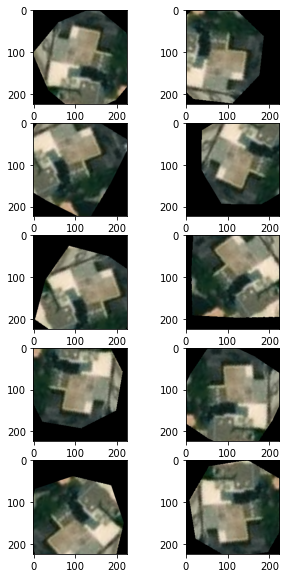

In [10]:
plt.figure(figsize=(5,10))
def view_data(trainn_ds, index):
    for i in range(1,6):
        images = trainn_ds[index]
        view1, view2 = images
        plt.subplot(5,2,2*i-1)
        plt.imshow(view1.permute(1,2,0))
        plt.subplot(5,2,2*i)
        plt.imshow(view2.permute(1,2,0))

view_data(trainn_ds, 50)

In [11]:
BATCH_SIZE = 256

# Building the data loader
train_dl = torch.utils.data.DataLoader(
    trainn_ds,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=os.cpu_count(),
    drop_last=True,
    pin_memory=True,
)

In [12]:
class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()
    def forward(self, x):
        return x

# simclr network
class SimCLR(nn.Module):
    def __init__(self, linear_eval=False):
        super().__init__()
        self.linear_eval = None
        resnet50 = models.resnet50(pretrained=True)
        resnet50.fc = Identity()
        self.encoder = resnet50
        self.projection = nn.Sequential(
            nn.Linear(2048, 1024),
            nn.ReLU(),
            nn.Linear(1024, 128)
        )
    def forward(self, x):
        if not self.linear_eval:
            x = torch.cat(x, dim=0)
        
        encoding = self.encoder(x)
        projection = self.projection(encoding) 
        return projection

In [13]:
LABELS = torch.cat([torch.arange(BATCH_SIZE) for i in range(2)], dim=0)
LABELS = (LABELS.unsqueeze(0) == LABELS.unsqueeze(1)).float() # Creates a one-hot with broadcasting
LABELS = LABELS.to(DEVICE) #128,128

# contrastive loss
def cont_loss(features, temp):
    """
    The NTxent Loss.
    
    Args:
        z1: The projection of the first branch
        z2: The projeciton of the second branch
    
    Returns:
        the NTxent loss
    """
    similarity_matrix = torch.matmul(features, features.T) # 128, 128
    # discard the main diagonal from both: labels and similarities matrix
    mask = torch.eye(LABELS.shape[0], dtype=torch.bool).to(DEVICE)
    # ~mask is the negative of the mask
    # the view is required to bring the matrix back to shape
    labels = LABELS[~mask].view(LABELS.shape[0], -1) # 128, 127
    similarity_matrix = similarity_matrix[~mask].view(similarity_matrix.shape[0], -1) # 128, 127

    # select and combine multiple positives
    positives = similarity_matrix[labels.bool()].view(labels.shape[0], -1) # 128, 1

    # select only the negatives
    negatives = similarity_matrix[~labels.bool()].view(similarity_matrix.shape[0], -1) # 128, 126

    logits = torch.cat([positives, negatives], dim=1) # 128, 127
    labels = torch.zeros(logits.shape[0], dtype=torch.long).to(DEVICE)

    logits = logits / temp
    return logits, labels

In [14]:
LABELS = torch.cat([torch.arange(BATCH_SIZE) for i in range(2)], dim=0)
LABELS

tensor([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
         14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,
         28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,
         42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,
         56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,  69,
         70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,
         84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,
         98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111,
        112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125,
        126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139,
        140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153,
        154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167,
        168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 1

In [15]:
LABELS = (LABELS.unsqueeze(0) == LABELS.unsqueeze(1)).float() # Creates a one-hot with broadcasting
LABELS

tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.]])

### LARS class implementation

In [16]:
import torch
from torch import nn
from torch.optim.optimizer import Optimizer, required
class LARS(Optimizer): 

    def __init__(
        self,
        params,
        lr=required,
        momentum: float = 0,
        dampening: float = 0,
        weight_decay: float = 0,
        nesterov: bool = False,
        trust_coefficient: float = 0.001,
        eps: float = 1e-8,
    ):
        if lr is not required and lr < 0.0:
            raise ValueError(f"Invalid learning rate: {lr}")
        if momentum < 0.0:
            raise ValueError(f"Invalid momentum value: {momentum}")
        if weight_decay < 0.0:
            raise ValueError(f"Invalid weight_decay value: {weight_decay}")

        defaults = dict(lr=lr, momentum=momentum, dampening=dampening, weight_decay=weight_decay, nesterov=nesterov)
        if nesterov and (momentum <= 0 or dampening != 0):
            raise ValueError("Nesterov momentum requires a momentum and zero dampening")

        self.eps = eps
        self.trust_coefficient = trust_coefficient

        super().__init__(params, defaults)

    def __setstate__(self, state):
        super().__setstate__(state)

        for group in self.param_groups:
            group.setdefault("nesterov", False)

    @torch.no_grad()
    def step(self, closure=None):
        """Performs a single optimization step.

        Args:
            closure (callable, optional): A closure that reevaluates the model
                and returns the loss.
        """
        loss = None
        if closure is not None:
            with torch.enable_grad():
                loss = closure()

        # exclude scaling for params with 0 weight decay
        for group in self.param_groups:
            weight_decay = group["weight_decay"]
            momentum = group["momentum"]
            dampening = group["dampening"]
            nesterov = group["nesterov"]

            for p in group["params"]:
                if p.grad is None:
                    continue

                d_p = p.grad
                p_norm = torch.norm(p.data)
                g_norm = torch.norm(p.grad.data)

                # lars scaling + weight decay part
                if weight_decay != 0:
                    if p_norm != 0 and g_norm != 0:
                        lars_lr = p_norm / (g_norm + p_norm * weight_decay + self.eps)
                        lars_lr *= self.trust_coefficient

                        d_p = d_p.add(p, alpha=weight_decay)
                        d_p *= lars_lr

                # sgd part
                if momentum != 0:
                    param_state = self.state[p]
                    if "momentum_buffer" not in param_state:
                        buf = param_state["momentum_buffer"] = torch.clone(d_p).detach()
                    else:
                        buf = param_state["momentum_buffer"]
                        buf.mul_(momentum).add_(d_p, alpha=1 - dampening)
                    if nesterov:
                        d_p = d_p.add(buf, alpha=momentum)
                    else:
                        d_p = buf

                p.add_(d_p, alpha=-group["lr"])

        return loss


In [17]:
from torch import optim
simclr_model = SimCLR().to(DEVICE)       # network model
criterion = nn.CrossEntropyLoss().to(DEVICE)        # loss
# optimizer = torch.optim.Adam(simclr_model.parameters(), lr=0.79, weight_decay=1e-6)     # optimizer
# optimizer = LARS(optim.SGD(clr_model.parameters(), lr=0.59, weight_decay=1e-6))
optimizer = torch.optim.SGD(simclr_model.parameters(), lr=0.001/2, momentum=0.9, weight_decay=0.0005, nesterov=True)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=1000)

In [18]:
from tqdm import tqdm

EPOCHS = 101
checkpoint = 1
for epoch in range(EPOCHS):
    t0 = time.time()
    running_loss = 0.0
    for i, views in enumerate(tqdm(train_dl)):
        projections = simclr_model([view.to(DEVICE) for view in views])
        logits, labels = cont_loss(projections, temp=0.5)
        loss = criterion(logits, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    scheduler.step()
        # print statistics
    if(epoch % 10 == 0) :                        
        print(f'EPOCH: {epoch+1} BATCH: {i+1} LOSS: {(running_loss/100):.4f} ')
        
        # Checkpoint 
        torch.save(simclr_model.state_dict(), f'simclr_resnet50_pre_two_stage_{checkpoint}') 
        checkpoint += 1 
    running_loss = 0.0
    print(f'Time taken: {((time.time()-t0)/60):.3f} mins')

100%|███████████████████████████████████████████| 52/52 [03:28<00:00,  4.01s/it]


EPOCH: 1 BATCH: 52 LOSS: 2.8748 
Time taken: 3.480 mins


100%|███████████████████████████████████████████| 52/52 [02:25<00:00,  2.80s/it]


Time taken: 2.429 mins


100%|███████████████████████████████████████████| 52/52 [02:27<00:00,  2.83s/it]


Time taken: 2.455 mins


100%|███████████████████████████████████████████| 52/52 [02:25<00:00,  2.80s/it]


Time taken: 2.430 mins


100%|███████████████████████████████████████████| 52/52 [02:25<00:00,  2.80s/it]


Time taken: 2.423 mins


100%|███████████████████████████████████████████| 52/52 [02:24<00:00,  2.79s/it]


Time taken: 2.416 mins


100%|███████████████████████████████████████████| 52/52 [02:26<00:00,  2.81s/it]


Time taken: 2.438 mins


100%|███████████████████████████████████████████| 52/52 [02:26<00:00,  2.81s/it]


Time taken: 2.437 mins


100%|███████████████████████████████████████████| 52/52 [02:26<00:00,  2.81s/it]


Time taken: 2.434 mins


100%|███████████████████████████████████████████| 52/52 [02:25<00:00,  2.80s/it]


Time taken: 2.427 mins


100%|███████████████████████████████████████████| 52/52 [02:23<00:00,  2.77s/it]


EPOCH: 11 BATCH: 52 LOSS: 0.0405 
Time taken: 2.401 mins


100%|███████████████████████████████████████████| 52/52 [02:24<00:00,  2.78s/it]


Time taken: 2.409 mins


100%|███████████████████████████████████████████| 52/52 [02:26<00:00,  2.82s/it]


Time taken: 2.446 mins


100%|███████████████████████████████████████████| 52/52 [02:27<00:00,  2.84s/it]


Time taken: 2.463 mins


100%|███████████████████████████████████████████| 52/52 [02:23<00:00,  2.76s/it]


Time taken: 2.390 mins


100%|███████████████████████████████████████████| 52/52 [02:24<00:00,  2.78s/it]


Time taken: 2.408 mins


100%|███████████████████████████████████████████| 52/52 [02:27<00:00,  2.83s/it]


Time taken: 2.456 mins


100%|███████████████████████████████████████████| 52/52 [02:27<00:00,  2.84s/it]


Time taken: 2.458 mins


100%|███████████████████████████████████████████| 52/52 [02:23<00:00,  2.76s/it]


Time taken: 2.395 mins


100%|███████████████████████████████████████████| 52/52 [02:23<00:00,  2.76s/it]


Time taken: 2.395 mins


100%|███████████████████████████████████████████| 52/52 [02:24<00:00,  2.78s/it]


EPOCH: 21 BATCH: 52 LOSS: 0.0176 
Time taken: 2.413 mins


100%|███████████████████████████████████████████| 52/52 [02:25<00:00,  2.79s/it]


Time taken: 2.420 mins


100%|███████████████████████████████████████████| 52/52 [02:27<00:00,  2.83s/it]


Time taken: 2.453 mins


100%|███████████████████████████████████████████| 52/52 [02:24<00:00,  2.77s/it]


Time taken: 2.401 mins


100%|███████████████████████████████████████████| 52/52 [02:26<00:00,  2.81s/it]


Time taken: 2.440 mins


100%|███████████████████████████████████████████| 52/52 [02:26<00:00,  2.82s/it]


Time taken: 2.445 mins


100%|███████████████████████████████████████████| 52/52 [02:26<00:00,  2.82s/it]


Time taken: 2.443 mins


100%|███████████████████████████████████████████| 52/52 [02:25<00:00,  2.80s/it]


Time taken: 2.425 mins


100%|███████████████████████████████████████████| 52/52 [02:25<00:00,  2.79s/it]


Time taken: 2.420 mins


100%|███████████████████████████████████████████| 52/52 [02:25<00:00,  2.79s/it]


Time taken: 2.421 mins


100%|███████████████████████████████████████████| 52/52 [02:25<00:00,  2.79s/it]


EPOCH: 31 BATCH: 52 LOSS: 0.0101 
Time taken: 2.424 mins


100%|███████████████████████████████████████████| 52/52 [02:24<00:00,  2.79s/it]


Time taken: 2.415 mins


100%|███████████████████████████████████████████| 52/52 [02:22<00:00,  2.74s/it]


Time taken: 2.374 mins


100%|███████████████████████████████████████████| 52/52 [02:25<00:00,  2.80s/it]


Time taken: 2.423 mins


100%|███████████████████████████████████████████| 52/52 [02:23<00:00,  2.77s/it]


Time taken: 2.399 mins


100%|███████████████████████████████████████████| 52/52 [02:24<00:00,  2.78s/it]


Time taken: 2.406 mins


100%|███████████████████████████████████████████| 52/52 [02:25<00:00,  2.80s/it]


Time taken: 2.426 mins


100%|███████████████████████████████████████████| 52/52 [02:26<00:00,  2.82s/it]


Time taken: 2.448 mins


100%|███████████████████████████████████████████| 52/52 [02:26<00:00,  2.82s/it]


Time taken: 2.443 mins


100%|███████████████████████████████████████████| 52/52 [02:24<00:00,  2.78s/it]


Time taken: 2.412 mins


100%|███████████████████████████████████████████| 52/52 [02:26<00:00,  2.82s/it]


EPOCH: 41 BATCH: 52 LOSS: 0.0077 
Time taken: 2.444 mins


100%|███████████████████████████████████████████| 52/52 [02:26<00:00,  2.81s/it]


Time taken: 2.434 mins


100%|███████████████████████████████████████████| 52/52 [02:25<00:00,  2.80s/it]


Time taken: 2.428 mins


100%|███████████████████████████████████████████| 52/52 [02:25<00:00,  2.79s/it]


Time taken: 2.420 mins


100%|███████████████████████████████████████████| 52/52 [02:25<00:00,  2.79s/it]


Time taken: 2.418 mins


100%|███████████████████████████████████████████| 52/52 [02:23<00:00,  2.76s/it]


Time taken: 2.394 mins


100%|███████████████████████████████████████████| 52/52 [02:26<00:00,  2.83s/it]


Time taken: 2.450 mins


100%|███████████████████████████████████████████| 52/52 [02:23<00:00,  2.76s/it]


Time taken: 2.393 mins


100%|███████████████████████████████████████████| 52/52 [02:25<00:00,  2.80s/it]


Time taken: 2.425 mins


100%|███████████████████████████████████████████| 52/52 [02:25<00:00,  2.80s/it]


Time taken: 2.424 mins


100%|███████████████████████████████████████████| 52/52 [02:27<00:00,  2.83s/it]


EPOCH: 51 BATCH: 52 LOSS: 0.0062 
Time taken: 2.453 mins


100%|███████████████████████████████████████████| 52/52 [02:26<00:00,  2.82s/it]


Time taken: 2.445 mins


100%|███████████████████████████████████████████| 52/52 [02:25<00:00,  2.79s/it]


Time taken: 2.419 mins


100%|███████████████████████████████████████████| 52/52 [02:27<00:00,  2.83s/it]


Time taken: 2.453 mins


100%|███████████████████████████████████████████| 52/52 [02:23<00:00,  2.75s/it]


Time taken: 2.387 mins


100%|███████████████████████████████████████████| 52/52 [02:24<00:00,  2.77s/it]


Time taken: 2.402 mins


100%|███████████████████████████████████████████| 52/52 [02:27<00:00,  2.83s/it]


Time taken: 2.457 mins


100%|███████████████████████████████████████████| 52/52 [02:28<00:00,  2.86s/it]


Time taken: 2.478 mins


100%|███████████████████████████████████████████| 52/52 [02:25<00:00,  2.79s/it]


Time taken: 2.417 mins


100%|███████████████████████████████████████████| 52/52 [02:24<00:00,  2.77s/it]


Time taken: 2.400 mins


100%|███████████████████████████████████████████| 52/52 [02:26<00:00,  2.82s/it]


EPOCH: 61 BATCH: 52 LOSS: 0.0051 
Time taken: 2.448 mins


100%|███████████████████████████████████████████| 52/52 [02:24<00:00,  2.78s/it]


Time taken: 2.409 mins


100%|███████████████████████████████████████████| 52/52 [02:28<00:00,  2.85s/it]


Time taken: 2.469 mins


100%|███████████████████████████████████████████| 52/52 [02:27<00:00,  2.84s/it]


Time taken: 2.463 mins


100%|███████████████████████████████████████████| 52/52 [02:25<00:00,  2.80s/it]


Time taken: 2.426 mins


100%|███████████████████████████████████████████| 52/52 [02:25<00:00,  2.80s/it]


Time taken: 2.424 mins


100%|███████████████████████████████████████████| 52/52 [02:26<00:00,  2.82s/it]


Time taken: 2.442 mins


100%|███████████████████████████████████████████| 52/52 [02:25<00:00,  2.81s/it]


Time taken: 2.432 mins


100%|███████████████████████████████████████████| 52/52 [02:27<00:00,  2.83s/it]


Time taken: 2.456 mins


100%|███████████████████████████████████████████| 52/52 [02:24<00:00,  2.78s/it]


Time taken: 2.413 mins


100%|███████████████████████████████████████████| 52/52 [02:25<00:00,  2.79s/it]


EPOCH: 71 BATCH: 52 LOSS: 0.0041 
Time taken: 2.420 mins


100%|███████████████████████████████████████████| 52/52 [02:25<00:00,  2.79s/it]


Time taken: 2.422 mins


100%|███████████████████████████████████████████| 52/52 [02:24<00:00,  2.79s/it]


Time taken: 2.416 mins


100%|███████████████████████████████████████████| 52/52 [02:27<00:00,  2.83s/it]


Time taken: 2.453 mins


100%|███████████████████████████████████████████| 52/52 [02:24<00:00,  2.79s/it]


Time taken: 2.414 mins


100%|███████████████████████████████████████████| 52/52 [02:27<00:00,  2.83s/it]


Time taken: 2.455 mins


100%|███████████████████████████████████████████| 52/52 [02:24<00:00,  2.78s/it]


Time taken: 2.409 mins


100%|███████████████████████████████████████████| 52/52 [02:24<00:00,  2.77s/it]


Time taken: 2.405 mins


100%|███████████████████████████████████████████| 52/52 [02:23<00:00,  2.77s/it]


Time taken: 2.399 mins


100%|███████████████████████████████████████████| 52/52 [02:23<00:00,  2.76s/it]


Time taken: 2.389 mins


100%|███████████████████████████████████████████| 52/52 [02:25<00:00,  2.81s/it]


EPOCH: 81 BATCH: 52 LOSS: 0.0038 
Time taken: 2.433 mins


100%|███████████████████████████████████████████| 52/52 [02:23<00:00,  2.76s/it]


Time taken: 2.391 mins


100%|███████████████████████████████████████████| 52/52 [02:26<00:00,  2.82s/it]


Time taken: 2.448 mins


100%|███████████████████████████████████████████| 52/52 [02:27<00:00,  2.84s/it]


Time taken: 2.459 mins


100%|███████████████████████████████████████████| 52/52 [02:25<00:00,  2.80s/it]


Time taken: 2.428 mins


100%|███████████████████████████████████████████| 52/52 [02:25<00:00,  2.80s/it]


Time taken: 2.429 mins


100%|███████████████████████████████████████████| 52/52 [02:24<00:00,  2.77s/it]


Time taken: 2.402 mins


100%|███████████████████████████████████████████| 52/52 [02:23<00:00,  2.76s/it]


Time taken: 2.388 mins


100%|███████████████████████████████████████████| 52/52 [02:25<00:00,  2.80s/it]


Time taken: 2.430 mins


100%|███████████████████████████████████████████| 52/52 [02:27<00:00,  2.83s/it]


Time taken: 2.455 mins


100%|███████████████████████████████████████████| 52/52 [02:28<00:00,  2.85s/it]


EPOCH: 91 BATCH: 52 LOSS: 0.0032 
Time taken: 2.469 mins


100%|███████████████████████████████████████████| 52/52 [02:27<00:00,  2.84s/it]


Time taken: 2.458 mins


100%|███████████████████████████████████████████| 52/52 [02:26<00:00,  2.82s/it]


Time taken: 2.447 mins


100%|███████████████████████████████████████████| 52/52 [02:26<00:00,  2.82s/it]


Time taken: 2.441 mins


100%|███████████████████████████████████████████| 52/52 [02:25<00:00,  2.79s/it]


Time taken: 2.419 mins


100%|███████████████████████████████████████████| 52/52 [02:26<00:00,  2.81s/it]


Time taken: 2.435 mins


100%|███████████████████████████████████████████| 52/52 [02:23<00:00,  2.76s/it]


Time taken: 2.396 mins


100%|███████████████████████████████████████████| 52/52 [02:24<00:00,  2.79s/it]


Time taken: 2.416 mins


100%|███████████████████████████████████████████| 52/52 [02:23<00:00,  2.76s/it]


Time taken: 2.393 mins


100%|███████████████████████████████████████████| 52/52 [02:27<00:00,  2.83s/it]


Time taken: 2.453 mins


100%|███████████████████████████████████████████| 52/52 [02:26<00:00,  2.82s/it]

EPOCH: 101 BATCH: 52 LOSS: 0.0032 
Time taken: 2.442 mins


# Downstream Task

In [18]:
from torchvision.transforms import (
    CenterCrop,
    Resize
)

In [19]:
# transforms

resize = Resize(255)
ccrop = CenterCrop(224)
ttensor = ToTensor()

custom_transform = Compose([
    resize,
    ccrop,
    ttensor,
])

In [20]:
# train and valid dataset

train2_ds = ImageFolder(
    root="/home/ccet/SIH/Data/ind-data/UCMerced_LandUse/train/",
    transform=custom_transform
)
valid2_ds = ImageFolder(
    root="/home/ccet/SIH/Data/ind-data/UCMerced_LandUse/test/",
    transform=custom_transform
)
test2_ds = ImageFolder(
    root="/home/ccet/SIH/Data/ind-data/UCMerced_LandUse/val/",
    transform=custom_transform
)

nu_classes = 2

BATCH_SIZE = 256

# train_size = int(0.8 * len(ds))
# valid_size = len(ds) - train_size
# train_ds, valid_ds = torch.utils.data.random_split(ds, [train_size, valid_size])

# print(len(train_ds))
# print(len(valid_ds))

# Building the data loader
train_dl = torch.utils.data.DataLoader(
    train2_ds,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=os.cpu_count(),
    drop_last=True,
    pin_memory=True,
)

valid_dl = torch.utils.data.DataLoader(
    valid2_ds,
    batch_size=128,
    shuffle=True,
    num_workers=os.cpu_count(),
    drop_last=True,
    pin_memory=True,
)
test_dl = torch.utils.data.DataLoader(
    test2_ds,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=os.cpu_count(),
    drop_last=True,
    pin_memory=True,
)

In [21]:
class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()
    def forward(self, x):
        return x

    
# classifier    
class LinearEvaluation(nn.Module):
    def __init__(self, model, nu_classes):
        super().__init__()
        simclr = model
        simclr.linear_eval = True
        simclr.projection = Identity()
        self.simclr = simclr
        for param in self.simclr.parameters():
            param.requires_grad = True
        self.linear = nn.Sequential(
            nn.Linear(2048, 512),
            nn.ReLU(),
            nn.Linear(512, nu_classes))
    def forward(self, x):
        encoding = self.simclr(x)
        pred = self.linear(encoding) 
        return pred

In [22]:
simclr_model.load_state_dict(torch.load('simclr_resnet50_pre_two_stage_11')) #load_tar
eval_model = LinearEvaluation(simclr_model, nu_classes).to(DEVICE)
criterion = nn.CrossEntropyLoss().to(DEVICE)
optimizer = LARS(eval_model.parameters(), lr=0.005, momentum=0.9,  weight_decay=1e-6, nesterov=True)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=1000)

In [23]:
cntr=0

for child in eval_model.children():
    cntr+=1
    print(child)

SimCLR(
  (encoder): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (

In [24]:
eval_model.children()

<generator object Module.children at 0x7fa41076dba0>

In [25]:
ct = 0
for child in eval_model.children():
    ct += 1
    if ct < 2:
        for param in child.parameters():
            param.requires_grad = False

In [26]:
from tqdm import tqdm
EPOCHS = 10
for epoch in range(EPOCHS):
    t0 = time.time()
    running_loss = 0.0
    for i, element in enumerate(tqdm(train_dl)):
        image, label = element
        image = image.to(DEVICE)
        label = label.to(DEVICE)
        pred = eval_model(image)
#         print(image.shape)
#         print(pred.shape)
#         print(label.shape)
        loss = criterion(pred, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    scheduler.step()
    if(epoch % 10 == 0) :                        
        print(f'EPOCH: {epoch+1} BATCH: {i+1} LOSS: {(running_loss/100):.4f} ')
    running_loss = 0.0
#     print(f'Time taken: {((time.time()-t0)/60):.3f} mins')

100%|█████████████████████████████████████████████| 5/5 [00:11<00:00,  2.28s/it]


EPOCH: 1 BATCH: 5 LOSS: 0.0390 


100%|█████████████████████████████████████████████| 5/5 [00:03<00:00,  1.59it/s]


In [27]:
ct = 0
for child in eval_model.children():
    ct += 1
    if ct <= 2:
        for param in child.parameters():
            param.requires_grad = True

In [28]:
train_loss = list()
train_acc= list()
val_loss= list()
val_acc= list()
from tqdm import tqdm
epochs = 100
for epoch in range(epochs):
    accuracies = list()
    class_losses = list()
    eval_model.train()
    for class_batch in tqdm(train_dl):
        x, y = class_batch
        x = x.to(DEVICE)
        y = y.to(DEVICE)
       
        logit = eval_model(x)
        classification_loss = criterion(logit, y)
        class_losses.append(classification_loss.item())

        optimizer.zero_grad()
        classification_loss.backward()
        optimizer.step()
        accuracies.append(y.eq(logit.detach().argmax(dim =1)).float().mean())
    scheduler.step()  
    if (epoch+1)%5==0:
        torch.save(eval_model.state_dict(), f'cl1_simclreval_newdata_{epoch+1}')
        print(f"saved checkpoint for epoch {epoch + 1}")

    train_loss.append(class_losses)
    train_acc.append(accuracies)
    print(f'Epoch {epoch + 1}')
    print(f'classification training loss: {torch.tensor(class_losses).mean():.5f}')
    print(f'classification training accuracy: {torch.tensor(accuracies).mean():.5f}', 
          end ='\n\n')
    

    losses = list()
    accuracies = list()
    eval_model.eval()
    for batch in tqdm(valid_dl):
        x, y = batch
        x = x.to(DEVICE)
        y = y.to(DEVICE)
        with torch.no_grad():
            logit =eval_model(x)

        loss = criterion(logit, y)

        losses.append(loss.item())
        accuracies.append(y.eq(logit.detach().argmax(dim =1)).float().mean())
    
    val_loss.append(losses)
    val_acc.append(accuracies)
    print(f'Epoch {epoch + 1}')
    print(f'classification validation loss: {torch.tensor(losses).mean():.5f}')
    print(f'classification validation accuracy: {torch.tensor(accuracies).mean():.5f}', 
          end ='\n\n')


100%|█████████████████████████████████████████████| 5/5 [00:06<00:00,  1.32s/it]


Epoch 1
classification training loss: 0.66832
classification training accuracy: 0.65156



100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.22s/it]


Epoch 1
classification validation loss: 0.65322
classification validation accuracy: 0.75781



100%|█████████████████████████████████████████████| 5/5 [00:06<00:00,  1.28s/it]


Epoch 2
classification training loss: 0.65566
classification training accuracy: 0.74531



100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.57s/it]


Epoch 2
classification validation loss: 0.64674
classification validation accuracy: 0.81250



100%|█████████████████████████████████████████████| 5/5 [00:06<00:00,  1.31s/it]


Epoch 3
classification training loss: 0.64181
classification training accuracy: 0.81719



100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.50s/it]


Epoch 3
classification validation loss: 0.63294
classification validation accuracy: 0.83594



100%|█████████████████████████████████████████████| 5/5 [00:06<00:00,  1.29s/it]


Epoch 4
classification training loss: 0.62756
classification training accuracy: 0.85312



100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.52s/it]


Epoch 4
classification validation loss: 0.61554
classification validation accuracy: 0.91406



100%|█████████████████████████████████████████████| 5/5 [00:06<00:00,  1.30s/it]


saved checkpoint for epoch 5
Epoch 5
classification training loss: 0.61188
classification training accuracy: 0.87031



100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.61s/it]


Epoch 5
classification validation loss: 0.60993
classification validation accuracy: 0.86719



100%|█████████████████████████████████████████████| 5/5 [00:06<00:00,  1.27s/it]


Epoch 6
classification training loss: 0.59854
classification training accuracy: 0.88047



100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.42s/it]


Epoch 6
classification validation loss: 0.58657
classification validation accuracy: 0.90625



100%|█████████████████████████████████████████████| 5/5 [00:06<00:00,  1.28s/it]


Epoch 7
classification training loss: 0.58356
classification training accuracy: 0.87969



100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.48s/it]


Epoch 7
classification validation loss: 0.56828
classification validation accuracy: 0.89844



100%|█████████████████████████████████████████████| 5/5 [00:06<00:00,  1.33s/it]


Epoch 8
classification training loss: 0.56679
classification training accuracy: 0.88906



100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.42s/it]


Epoch 8
classification validation loss: 0.56597
classification validation accuracy: 0.90625



100%|█████████████████████████████████████████████| 5/5 [00:06<00:00,  1.35s/it]


Epoch 9
classification training loss: 0.55534
classification training accuracy: 0.87813



100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.49s/it]


Epoch 9
classification validation loss: 0.55447
classification validation accuracy: 0.87500



100%|█████████████████████████████████████████████| 5/5 [00:06<00:00,  1.31s/it]


saved checkpoint for epoch 10
Epoch 10
classification training loss: 0.54418
classification training accuracy: 0.87344



100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.43s/it]


Epoch 10
classification validation loss: 0.53776
classification validation accuracy: 0.89062



100%|█████████████████████████████████████████████| 5/5 [00:06<00:00,  1.30s/it]


Epoch 11
classification training loss: 0.52792
classification training accuracy: 0.88437



100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.53s/it]


Epoch 11
classification validation loss: 0.53429
classification validation accuracy: 0.86719



100%|█████████████████████████████████████████████| 5/5 [00:06<00:00,  1.31s/it]


Epoch 12
classification training loss: 0.51419
classification training accuracy: 0.88437



100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.53s/it]


Epoch 12
classification validation loss: 0.51909
classification validation accuracy: 0.88281



100%|█████████████████████████████████████████████| 5/5 [00:06<00:00,  1.28s/it]


Epoch 13
classification training loss: 0.50364
classification training accuracy: 0.87734



100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.31s/it]


Epoch 13
classification validation loss: 0.50605
classification validation accuracy: 0.88281



100%|█████████████████████████████████████████████| 5/5 [00:06<00:00,  1.29s/it]


Epoch 14
classification training loss: 0.49237
classification training accuracy: 0.87422



100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.49s/it]


Epoch 14
classification validation loss: 0.49369
classification validation accuracy: 0.86719



100%|█████████████████████████████████████████████| 5/5 [00:06<00:00,  1.28s/it]


saved checkpoint for epoch 15
Epoch 15
classification training loss: 0.48141
classification training accuracy: 0.87500



100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.42s/it]


Epoch 15
classification validation loss: 0.48197
classification validation accuracy: 0.85938



100%|█████████████████████████████████████████████| 5/5 [00:06<00:00,  1.29s/it]


Epoch 16
classification training loss: 0.46733
classification training accuracy: 0.87734



100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.44s/it]


Epoch 16
classification validation loss: 0.47442
classification validation accuracy: 0.88281



100%|█████████████████████████████████████████████| 5/5 [00:06<00:00,  1.26s/it]


Epoch 17
classification training loss: 0.45869
classification training accuracy: 0.87187



100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.44s/it]


Epoch 17
classification validation loss: 0.45654
classification validation accuracy: 0.86719



100%|█████████████████████████████████████████████| 5/5 [00:06<00:00,  1.28s/it]


Epoch 18
classification training loss: 0.44962
classification training accuracy: 0.87422



100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.46s/it]


Epoch 18
classification validation loss: 0.45719
classification validation accuracy: 0.85938



100%|█████████████████████████████████████████████| 5/5 [00:06<00:00,  1.29s/it]


Epoch 19
classification training loss: 0.43607
classification training accuracy: 0.87500



100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.43s/it]


Epoch 19
classification validation loss: 0.45066
classification validation accuracy: 0.85938



100%|█████████████████████████████████████████████| 5/5 [00:06<00:00,  1.33s/it]


saved checkpoint for epoch 20
Epoch 20
classification training loss: 0.42742
classification training accuracy: 0.87578



100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.46s/it]


Epoch 20
classification validation loss: 0.41716
classification validation accuracy: 0.89062



100%|█████████████████████████████████████████████| 5/5 [00:06<00:00,  1.29s/it]


Epoch 21
classification training loss: 0.41925
classification training accuracy: 0.87500



100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.47s/it]


Epoch 21
classification validation loss: 0.41089
classification validation accuracy: 0.89062



100%|█████████████████████████████████████████████| 5/5 [00:06<00:00,  1.32s/it]


Epoch 22
classification training loss: 0.40749
classification training accuracy: 0.87813



100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.48s/it]


Epoch 22
classification validation loss: 0.41086
classification validation accuracy: 0.87500



100%|█████████████████████████████████████████████| 5/5 [00:06<00:00,  1.30s/it]


Epoch 23
classification training loss: 0.40014
classification training accuracy: 0.87422



100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.38s/it]


Epoch 23
classification validation loss: 0.40398
classification validation accuracy: 0.86719



100%|█████████████████████████████████████████████| 5/5 [00:06<00:00,  1.33s/it]


Epoch 24
classification training loss: 0.39294
classification training accuracy: 0.87813



100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.46s/it]


Epoch 24
classification validation loss: 0.41380
classification validation accuracy: 0.85156



100%|█████████████████████████████████████████████| 5/5 [00:06<00:00,  1.27s/it]


saved checkpoint for epoch 25
Epoch 25
classification training loss: 0.37878
classification training accuracy: 0.88437



100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.50s/it]


Epoch 25
classification validation loss: 0.40248
classification validation accuracy: 0.85938



100%|█████████████████████████████████████████████| 5/5 [00:06<00:00,  1.30s/it]


Epoch 26
classification training loss: 0.36718
classification training accuracy: 0.88984



100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.42s/it]


Epoch 26
classification validation loss: 0.38583
classification validation accuracy: 0.86719



100%|█████████████████████████████████████████████| 5/5 [00:06<00:00,  1.32s/it]


Epoch 27
classification training loss: 0.36434
classification training accuracy: 0.88437



100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.51s/it]


Epoch 27
classification validation loss: 0.38297
classification validation accuracy: 0.85156



100%|█████████████████████████████████████████████| 5/5 [00:06<00:00,  1.36s/it]


Epoch 28
classification training loss: 0.35794
classification training accuracy: 0.87969



100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.50s/it]


Epoch 28
classification validation loss: 0.36336
classification validation accuracy: 0.86719



100%|█████████████████████████████████████████████| 5/5 [00:06<00:00,  1.33s/it]


Epoch 29
classification training loss: 0.34689
classification training accuracy: 0.88516



100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.49s/it]


Epoch 29
classification validation loss: 0.38070
classification validation accuracy: 0.83594



100%|█████████████████████████████████████████████| 5/5 [00:06<00:00,  1.33s/it]


saved checkpoint for epoch 30
Epoch 30
classification training loss: 0.34083
classification training accuracy: 0.88516



100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.43s/it]


Epoch 30
classification validation loss: 0.37059
classification validation accuracy: 0.85938



100%|█████████████████████████████████████████████| 5/5 [00:06<00:00,  1.29s/it]


Epoch 31
classification training loss: 0.33786
classification training accuracy: 0.87969



100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.40s/it]


Epoch 31
classification validation loss: 0.32654
classification validation accuracy: 0.89844



100%|█████████████████████████████████████████████| 5/5 [00:06<00:00,  1.31s/it]


Epoch 32
classification training loss: 0.32598
classification training accuracy: 0.88594



100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.46s/it]


Epoch 32
classification validation loss: 0.35233
classification validation accuracy: 0.86719



100%|█████████████████████████████████████████████| 5/5 [00:06<00:00,  1.31s/it]


Epoch 33
classification training loss: 0.31838
classification training accuracy: 0.88750



100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.45s/it]


Epoch 33
classification validation loss: 0.32773
classification validation accuracy: 0.87500



100%|█████████████████████████████████████████████| 5/5 [00:06<00:00,  1.29s/it]


Epoch 34
classification training loss: 0.30917
classification training accuracy: 0.89297



100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.50s/it]


Epoch 34
classification validation loss: 0.30846
classification validation accuracy: 0.89844



100%|█████████████████████████████████████████████| 5/5 [00:06<00:00,  1.33s/it]


saved checkpoint for epoch 35
Epoch 35
classification training loss: 0.30257
classification training accuracy: 0.89844



100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.43s/it]


Epoch 35
classification validation loss: 0.32629
classification validation accuracy: 0.86719



100%|█████████████████████████████████████████████| 5/5 [00:06<00:00,  1.30s/it]


Epoch 36
classification training loss: 0.29471
classification training accuracy: 0.89922



100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.43s/it]


Epoch 36
classification validation loss: 0.30776
classification validation accuracy: 0.89844



100%|█████████████████████████████████████████████| 5/5 [00:06<00:00,  1.33s/it]


Epoch 37
classification training loss: 0.28701
classification training accuracy: 0.90547



100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.50s/it]


Epoch 37
classification validation loss: 0.31276
classification validation accuracy: 0.89844



100%|█████████████████████████████████████████████| 5/5 [00:06<00:00,  1.30s/it]


Epoch 38
classification training loss: 0.28438
classification training accuracy: 0.90234



100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.32s/it]


Epoch 38
classification validation loss: 0.30950
classification validation accuracy: 0.88281



100%|█████████████████████████████████████████████| 5/5 [00:06<00:00,  1.30s/it]


Epoch 39
classification training loss: 0.27702
classification training accuracy: 0.90391



100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.37s/it]


Epoch 39
classification validation loss: 0.29756
classification validation accuracy: 0.89062



100%|█████████████████████████████████████████████| 5/5 [00:06<00:00,  1.32s/it]


saved checkpoint for epoch 40
Epoch 40
classification training loss: 0.27199
classification training accuracy: 0.90703



100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.34s/it]


Epoch 40
classification validation loss: 0.32499
classification validation accuracy: 0.85156



100%|█████████████████████████████████████████████| 5/5 [00:06<00:00,  1.33s/it]


Epoch 41
classification training loss: 0.26109
classification training accuracy: 0.91562



100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.49s/it]


Epoch 41
classification validation loss: 0.29118
classification validation accuracy: 0.89062



100%|█████████████████████████████████████████████| 5/5 [00:06<00:00,  1.29s/it]


Epoch 42
classification training loss: 0.25719
classification training accuracy: 0.91484



100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.46s/it]


Epoch 42
classification validation loss: 0.27491
classification validation accuracy: 0.89062



100%|█████████████████████████████████████████████| 5/5 [00:06<00:00,  1.31s/it]


Epoch 43
classification training loss: 0.24476
classification training accuracy: 0.93281



100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.41s/it]


Epoch 43
classification validation loss: 0.25980
classification validation accuracy: 0.92188



100%|█████████████████████████████████████████████| 5/5 [00:06<00:00,  1.31s/it]


Epoch 44
classification training loss: 0.24151
classification training accuracy: 0.92500



100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.47s/it]


Epoch 44
classification validation loss: 0.29745
classification validation accuracy: 0.86719



100%|█████████████████████████████████████████████| 5/5 [00:06<00:00,  1.31s/it]


saved checkpoint for epoch 45
Epoch 45
classification training loss: 0.23635
classification training accuracy: 0.93047



100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.34s/it]


Epoch 45
classification validation loss: 0.25852
classification validation accuracy: 0.90625



100%|█████████████████████████████████████████████| 5/5 [00:06<00:00,  1.31s/it]


Epoch 46
classification training loss: 0.23204
classification training accuracy: 0.92734



100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.45s/it]


Epoch 46
classification validation loss: 0.22176
classification validation accuracy: 0.95312



100%|█████████████████████████████████████████████| 5/5 [00:06<00:00,  1.31s/it]


Epoch 47
classification training loss: 0.23063
classification training accuracy: 0.92969



100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.47s/it]


Epoch 47
classification validation loss: 0.23947
classification validation accuracy: 0.91406



100%|█████████████████████████████████████████████| 5/5 [00:06<00:00,  1.32s/it]


Epoch 48
classification training loss: 0.21959
classification training accuracy: 0.93750



100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.47s/it]


Epoch 48
classification validation loss: 0.24432
classification validation accuracy: 0.89062



100%|█████████████████████████████████████████████| 5/5 [00:06<00:00,  1.28s/it]


Epoch 49
classification training loss: 0.21370
classification training accuracy: 0.93516



100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.44s/it]


Epoch 49
classification validation loss: 0.24575
classification validation accuracy: 0.89844



100%|█████████████████████████████████████████████| 5/5 [00:06<00:00,  1.31s/it]


saved checkpoint for epoch 50
Epoch 50
classification training loss: 0.20642
classification training accuracy: 0.94297



100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.34s/it]


Epoch 50
classification validation loss: 0.26822
classification validation accuracy: 0.87500



100%|█████████████████████████████████████████████| 5/5 [00:06<00:00,  1.33s/it]


Epoch 51
classification training loss: 0.20082
classification training accuracy: 0.94453



100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.47s/it]


Epoch 51
classification validation loss: 0.25012
classification validation accuracy: 0.88281



100%|█████████████████████████████████████████████| 5/5 [00:06<00:00,  1.30s/it]


Epoch 52
classification training loss: 0.19773
classification training accuracy: 0.94375



100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.33s/it]


Epoch 52
classification validation loss: 0.21783
classification validation accuracy: 0.91406



100%|█████████████████████████████████████████████| 5/5 [00:06<00:00,  1.29s/it]


Epoch 53
classification training loss: 0.19453
classification training accuracy: 0.95156



100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.37s/it]


Epoch 53
classification validation loss: 0.23378
classification validation accuracy: 0.90625



100%|█████████████████████████████████████████████| 5/5 [00:06<00:00,  1.32s/it]


Epoch 54
classification training loss: 0.18616
classification training accuracy: 0.95391



100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.46s/it]


Epoch 54
classification validation loss: 0.23173
classification validation accuracy: 0.91406



100%|█████████████████████████████████████████████| 5/5 [00:06<00:00,  1.33s/it]


saved checkpoint for epoch 55
Epoch 55
classification training loss: 0.17965
classification training accuracy: 0.95703



100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.52s/it]


Epoch 55
classification validation loss: 0.18494
classification validation accuracy: 0.96094



100%|█████████████████████████████████████████████| 5/5 [00:06<00:00,  1.29s/it]


Epoch 56
classification training loss: 0.17882
classification training accuracy: 0.95312



100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.46s/it]


Epoch 56
classification validation loss: 0.21101
classification validation accuracy: 0.92969



100%|█████████████████████████████████████████████| 5/5 [00:06<00:00,  1.31s/it]


Epoch 57
classification training loss: 0.17412
classification training accuracy: 0.95469



100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.52s/it]


Epoch 57
classification validation loss: 0.20775
classification validation accuracy: 0.95312



100%|█████████████████████████████████████████████| 5/5 [00:06<00:00,  1.29s/it]


Epoch 58
classification training loss: 0.16735
classification training accuracy: 0.96016



100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.49s/it]


Epoch 58
classification validation loss: 0.16489
classification validation accuracy: 0.96875



100%|█████████████████████████████████████████████| 5/5 [00:06<00:00,  1.32s/it]


Epoch 59
classification training loss: 0.16347
classification training accuracy: 0.96328



100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.44s/it]


Epoch 59
classification validation loss: 0.18958
classification validation accuracy: 0.93750



100%|█████████████████████████████████████████████| 5/5 [00:06<00:00,  1.33s/it]


saved checkpoint for epoch 60
Epoch 60
classification training loss: 0.15634
classification training accuracy: 0.96719



100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.43s/it]


Epoch 60
classification validation loss: 0.17624
classification validation accuracy: 0.96094



100%|█████████████████████████████████████████████| 5/5 [00:06<00:00,  1.31s/it]


Epoch 61
classification training loss: 0.15512
classification training accuracy: 0.96797



100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.47s/it]


Epoch 61
classification validation loss: 0.16039
classification validation accuracy: 0.95312



100%|█████████████████████████████████████████████| 5/5 [00:06<00:00,  1.29s/it]


Epoch 62
classification training loss: 0.14947
classification training accuracy: 0.96875



100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.47s/it]


Epoch 62
classification validation loss: 0.18252
classification validation accuracy: 0.95312



100%|█████████████████████████████████████████████| 5/5 [00:06<00:00,  1.30s/it]


Epoch 63
classification training loss: 0.13902
classification training accuracy: 0.97734



100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.50s/it]


Epoch 63
classification validation loss: 0.17707
classification validation accuracy: 0.95312



100%|█████████████████████████████████████████████| 5/5 [00:06<00:00,  1.32s/it]


Epoch 64
classification training loss: 0.13610
classification training accuracy: 0.97578



100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.40s/it]


Epoch 64
classification validation loss: 0.16113
classification validation accuracy: 0.96875



100%|█████████████████████████████████████████████| 5/5 [00:06<00:00,  1.28s/it]


saved checkpoint for epoch 65
Epoch 65
classification training loss: 0.13158
classification training accuracy: 0.97969



100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.42s/it]


Epoch 65
classification validation loss: 0.16741
classification validation accuracy: 0.94531



100%|█████████████████████████████████████████████| 5/5 [00:06<00:00,  1.32s/it]


Epoch 66
classification training loss: 0.13043
classification training accuracy: 0.97891



100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.51s/it]


Epoch 66
classification validation loss: 0.15131
classification validation accuracy: 0.96875



100%|█████████████████████████████████████████████| 5/5 [00:06<00:00,  1.36s/it]


Epoch 67
classification training loss: 0.12377
classification training accuracy: 0.98594



100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.56s/it]


Epoch 67
classification validation loss: 0.16791
classification validation accuracy: 0.96094



100%|█████████████████████████████████████████████| 5/5 [00:06<00:00,  1.31s/it]


Epoch 68
classification training loss: 0.11851
classification training accuracy: 0.98203



100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.50s/it]


Epoch 68
classification validation loss: 0.16413
classification validation accuracy: 0.96875



100%|█████████████████████████████████████████████| 5/5 [00:06<00:00,  1.35s/it]


Epoch 69
classification training loss: 0.11867
classification training accuracy: 0.98047



100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.48s/it]


Epoch 69
classification validation loss: 0.15779
classification validation accuracy: 0.94531



100%|█████████████████████████████████████████████| 5/5 [00:06<00:00,  1.33s/it]


saved checkpoint for epoch 70
Epoch 70
classification training loss: 0.11014
classification training accuracy: 0.98672



100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.42s/it]


Epoch 70
classification validation loss: 0.14743
classification validation accuracy: 0.96094



100%|█████████████████████████████████████████████| 5/5 [00:06<00:00,  1.34s/it]


Epoch 71
classification training loss: 0.10782
classification training accuracy: 0.98750



100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.49s/it]


Epoch 71
classification validation loss: 0.15491
classification validation accuracy: 0.96094



100%|█████████████████████████████████████████████| 5/5 [00:06<00:00,  1.32s/it]


Epoch 72
classification training loss: 0.10343
classification training accuracy: 0.98828



100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.52s/it]


Epoch 72
classification validation loss: 0.13946
classification validation accuracy: 0.97656



100%|█████████████████████████████████████████████| 5/5 [00:06<00:00,  1.35s/it]


Epoch 73
classification training loss: 0.09672
classification training accuracy: 0.98906



100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.48s/it]


Epoch 73
classification validation loss: 0.15215
classification validation accuracy: 0.96094



100%|█████████████████████████████████████████████| 5/5 [00:06<00:00,  1.35s/it]


Epoch 74
classification training loss: 0.09797
classification training accuracy: 0.99063



100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.56s/it]


Epoch 74
classification validation loss: 0.14995
classification validation accuracy: 0.96875



100%|█████████████████████████████████████████████| 5/5 [00:06<00:00,  1.30s/it]


saved checkpoint for epoch 75
Epoch 75
classification training loss: 0.09089
classification training accuracy: 0.99297



100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.46s/it]


Epoch 75
classification validation loss: 0.12881
classification validation accuracy: 0.97656



100%|█████████████████████████████████████████████| 5/5 [00:06<00:00,  1.33s/it]


Epoch 76
classification training loss: 0.08965
classification training accuracy: 0.99141



100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.41s/it]


Epoch 76
classification validation loss: 0.12710
classification validation accuracy: 0.97656



100%|█████████████████████████████████████████████| 5/5 [00:06<00:00,  1.28s/it]


Epoch 77
classification training loss: 0.09012
classification training accuracy: 0.99141



100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.51s/it]


Epoch 77
classification validation loss: 0.13468
classification validation accuracy: 0.96094



100%|█████████████████████████████████████████████| 5/5 [00:06<00:00,  1.34s/it]


Epoch 78
classification training loss: 0.08503
classification training accuracy: 0.98984



100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.45s/it]


Epoch 78
classification validation loss: 0.13410
classification validation accuracy: 0.96875



100%|█████████████████████████████████████████████| 5/5 [00:06<00:00,  1.33s/it]


Epoch 79
classification training loss: 0.08104
classification training accuracy: 0.99141



100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.44s/it]


Epoch 79
classification validation loss: 0.12567
classification validation accuracy: 0.96875



100%|█████████████████████████████████████████████| 5/5 [00:06<00:00,  1.33s/it]


saved checkpoint for epoch 80
Epoch 80
classification training loss: 0.07562
classification training accuracy: 0.99453



100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.41s/it]


Epoch 80
classification validation loss: 0.13789
classification validation accuracy: 0.96094



100%|█████████████████████████████████████████████| 5/5 [00:06<00:00,  1.29s/it]


Epoch 81
classification training loss: 0.07486
classification training accuracy: 0.99219



100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.42s/it]


Epoch 81
classification validation loss: 0.09539
classification validation accuracy: 0.97656



100%|█████████████████████████████████████████████| 5/5 [00:06<00:00,  1.28s/it]


Epoch 82
classification training loss: 0.07027
classification training accuracy: 0.99219



100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.47s/it]


Epoch 82
classification validation loss: 0.12468
classification validation accuracy: 0.96094



100%|█████████████████████████████████████████████| 5/5 [00:06<00:00,  1.32s/it]


Epoch 83
classification training loss: 0.06752
classification training accuracy: 0.99453



100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.47s/it]


Epoch 83
classification validation loss: 0.09714
classification validation accuracy: 0.97656



100%|█████████████████████████████████████████████| 5/5 [00:06<00:00,  1.31s/it]


Epoch 84
classification training loss: 0.06613
classification training accuracy: 0.99609



100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.52s/it]


Epoch 84
classification validation loss: 0.09897
classification validation accuracy: 0.97656



100%|█████████████████████████████████████████████| 5/5 [00:06<00:00,  1.29s/it]


saved checkpoint for epoch 85
Epoch 85
classification training loss: 0.06495
classification training accuracy: 0.99375



100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.42s/it]


Epoch 85
classification validation loss: 0.12301
classification validation accuracy: 0.96094



100%|█████████████████████████████████████████████| 5/5 [00:06<00:00,  1.29s/it]


Epoch 86
classification training loss: 0.05884
classification training accuracy: 0.99531



100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.43s/it]


Epoch 86
classification validation loss: 0.07601
classification validation accuracy: 0.99219



100%|█████████████████████████████████████████████| 5/5 [00:06<00:00,  1.29s/it]


Epoch 87
classification training loss: 0.05745
classification training accuracy: 0.99609



100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.46s/it]


Epoch 87
classification validation loss: 0.08771
classification validation accuracy: 0.97656



100%|█████████████████████████████████████████████| 5/5 [00:06<00:00,  1.29s/it]


Epoch 88
classification training loss: 0.05756
classification training accuracy: 0.99609



100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.42s/it]


Epoch 88
classification validation loss: 0.10871
classification validation accuracy: 0.96875



100%|█████████████████████████████████████████████| 5/5 [00:06<00:00,  1.31s/it]


Epoch 89
classification training loss: 0.05457
classification training accuracy: 0.99453



100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.62s/it]


Epoch 89
classification validation loss: 0.07892
classification validation accuracy: 0.97656



100%|█████████████████████████████████████████████| 5/5 [00:06<00:00,  1.30s/it]


saved checkpoint for epoch 90
Epoch 90
classification training loss: 0.05046
classification training accuracy: 0.99687



100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.42s/it]


Epoch 90
classification validation loss: 0.10718
classification validation accuracy: 0.97656



100%|█████████████████████████████████████████████| 5/5 [00:06<00:00,  1.32s/it]


Epoch 91
classification training loss: 0.05029
classification training accuracy: 0.99687



100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.49s/it]


Epoch 91
classification validation loss: 0.08233
classification validation accuracy: 0.97656



100%|█████████████████████████████████████████████| 5/5 [00:06<00:00,  1.31s/it]


Epoch 92
classification training loss: 0.04720
classification training accuracy: 0.99766



100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.44s/it]


Epoch 92
classification validation loss: 0.10904
classification validation accuracy: 0.96094



100%|█████████████████████████████████████████████| 5/5 [00:06<00:00,  1.32s/it]


Epoch 93
classification training loss: 0.04555
classification training accuracy: 0.99844



100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.38s/it]


Epoch 93
classification validation loss: 0.09285
classification validation accuracy: 0.96875



100%|█████████████████████████████████████████████| 5/5 [00:06<00:00,  1.32s/it]


Epoch 94
classification training loss: 0.04296
classification training accuracy: 0.99766



100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.52s/it]


Epoch 94
classification validation loss: 0.10238
classification validation accuracy: 0.96094



100%|█████████████████████████████████████████████| 5/5 [00:06<00:00,  1.34s/it]


saved checkpoint for epoch 95
Epoch 95
classification training loss: 0.04366
classification training accuracy: 0.99687



100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.49s/it]


Epoch 95
classification validation loss: 0.08443
classification validation accuracy: 0.96875



100%|█████████████████████████████████████████████| 5/5 [00:06<00:00,  1.33s/it]


Epoch 96
classification training loss: 0.04062
classification training accuracy: 0.99766



100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.47s/it]


Epoch 96
classification validation loss: 0.10121
classification validation accuracy: 0.96875



100%|█████████████████████████████████████████████| 5/5 [00:06<00:00,  1.33s/it]


Epoch 97
classification training loss: 0.03753
classification training accuracy: 0.99844



100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.50s/it]


Epoch 97
classification validation loss: 0.06514
classification validation accuracy: 0.99219



100%|█████████████████████████████████████████████| 5/5 [00:06<00:00,  1.33s/it]


Epoch 98
classification training loss: 0.03935
classification training accuracy: 0.99766



100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.51s/it]


Epoch 98
classification validation loss: 0.08786
classification validation accuracy: 0.97656



100%|█████████████████████████████████████████████| 5/5 [00:06<00:00,  1.32s/it]


Epoch 99
classification training loss: 0.03403
classification training accuracy: 0.99844



100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.45s/it]


Epoch 99
classification validation loss: 0.07440
classification validation accuracy: 0.97656



100%|█████████████████████████████████████████████| 5/5 [00:06<00:00,  1.32s/it]


saved checkpoint for epoch 100
Epoch 100
classification training loss: 0.03357
classification training accuracy: 0.99922



100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.34s/it]

Epoch 100
classification validation loss: 0.08731
classification validation accuracy: 0.96875



In [69]:
eval_model.load_state_dict(torch.load('cl1_simclreval_newdata_100')) #load_tar00

<All keys matched successfully>

In [70]:
from tqdm import tqdm
correct = 0
total = 0
preds = []
labels = []
with torch.no_grad():
    for i, element in enumerate(tqdm(test_dl)):
        image, label = element
        image = image.to(DEVICE)
        label = label.to(DEVICE)
        outputs = eval_model(image)
        _, predicted = torch.max(outputs.data, 1)
        preds += predicted.cpu().numpy().tolist()
        labels += label.cpu().numpy().tolist()
        total += label.size(0)
        correct += (predicted == label).sum().item()

print(f'Accuracy: {100 * correct / total} %')

100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.97s/it]

Accuracy: 97.265625 %


In [58]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler    
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, cohen_kappa_score

In [59]:
confusion_matrix_df = pd.DataFrame(confusion_matrix(labels, preds))

In [60]:
target_names = ['res', 'Nonres']

In [61]:
print(classification_report(labels, preds, target_names=target_names))

              precision    recall  f1-score   support

         res       0.98      0.99      0.99       218
      Nonres       0.94      0.89      0.92        38

    accuracy                           0.98       256
   macro avg       0.96      0.94      0.95       256
weighted avg       0.98      0.98      0.98       256



In [62]:
print(cohen_kappa_score(labels, preds, weights='quadratic'))

0.9052319842053307


In [63]:
print(cohen_kappa_score(labels, preds))

0.9052319842053307


<AxesSubplot:>

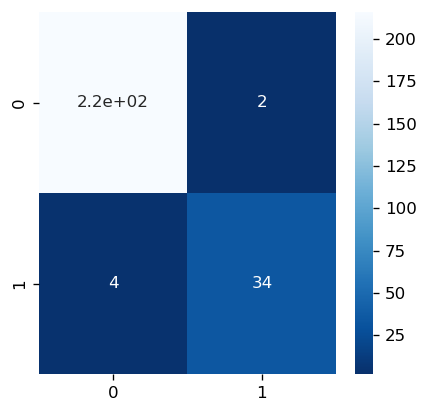

In [64]:
import seaborn as sn
plt.figure(figsize = (4,4),dpi=120)
sn.heatmap(confusion_matrix_df, annot=True, cmap="Blues_r")

In [65]:
import numpy as np
from sklearn.metrics import roc_curve, auc
# probs from log preds
#labels.reshape(-1,1)
probs = np.exp(labels[:])
# Compute ROC curve
fpr, tpr, thresholds = roc_curve(labels, preds)

# Compute ROC area
roc_auc = auc(fpr, tpr)
print('ROC area is {0}'.format(roc_auc))
#print(auc(fpr,tpr))

ROC area is 0.9427812650893289


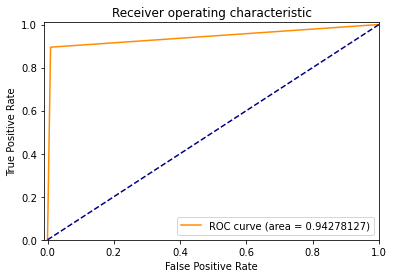

In [66]:
plt.figure()
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.8f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.01])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")